## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Tue Apr 02 06:34:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 399.24                 Driver Version: 399.24                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970    WDDM  | 00000000:01:00.0  On |                  N/A |
| 34%   29C    P8    18W / 250W |    319MiB /  4096MiB |      5%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import keras
import tensorflow as tf

from numba import cuda
cuda.select_device(0)
cuda.close()

import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=y_train.shape[-1], n_layers=4, num_neurons=[512, 256, 128, 64]):

    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons[:n_layers]):
        if i == 0:
            x = keras.layers.BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units,activation='relu',
                                   name='hidden_layers'+str(i+1))(x)
        else:
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units,activation='relu',
                                   name='hidden_layers'+str(i+1))(x)

    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

In [7]:
## 超參數設定

LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 512
OPTIMIZER = 'Adam'
SAVE_BEST_ONLY = [True, False]

In [8]:
def model_fitting( save_best_only, learning_rate=LEARNING_RATE, optimizer=OPTIMIZER, 
                  epochs=EPOCHS, batch_size=BATCH_SIZE, input_shape=x_train.shape[1:] ):

    keras.backend.clear_session()
    ########################################
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    ########################################
    
    model = build_mlp( input_shape=input_shape )
    model.summary()

    selector = {'SGD': keras.optimizers.SGD(lr=learning_rate, momentum=0.95, nesterov=True),
                'RMSprop': keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None),
                'AdaGrad': keras.optimizers.Adagrad(lr=learning_rate, epsilon=None), 
                'Adam': keras.optimizers.Adam(lr=learning_rate, epsilon=None, amsgrad=True)}

    optimizer = selector.get(optimizer)

    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    # 載入 Callbacks
    model_ckpt =  keras.callbacks.ModelCheckpoint(filepath='./tmp.h5', 
                                                 monitor='val_loss',
                                                 save_best_only = save_best_only )
    
    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=(x_test, y_test), 
                        shuffle=False, 
                        callbacks=[model_ckpt],
                        verbose=1)
    
    ##################
    sess.close()
    ##################
    
    return history

In [9]:
results = {}

for save_best_only in SAVE_BEST_ONLY:
    
    outcome = model_fitting(save_best_only=save_best_only)
    
    ########## Load back
    temp_model = keras.models.load_model("./tmp.h5")
    loss_loadback, acc_loadback = temp_model.evaluate(x_test, y_test)
    #########
    
    name_tag = f'Save Best Only={save_best_only}'
    results[name_tag] = {'train-loss': outcome.history['loss'],
                         'valid-loss': outcome.history['val_loss'],
                         'train-acc': outcome.history['acc'],
                         'valid-acc': outcome.history['val_acc'],
                        'loss_loadback' : loss_loadback,
                        'acc_loadback' : acc_loadback}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layers2 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layers3 (Dense)       (None, 128)               32896     
__________

50000/50000 [==============================] - 3s 64us/step - loss: 0.0115 - acc: 0.9973 - val_loss: 3.5220 - val_acc: 0.5362
Epoch 49/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.0075 - acc: 0.9985 - val_loss: 3.5475 - val_acc: 0.5347
Epoch 50/50
10000/10000 [==============================] - 1s 79us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidd

50000/50000 [==============================] - 3s 67us/step - loss: 0.0388 - acc: 0.9882 - val_loss: 3.4214 - val_acc: 0.5188
Epoch 45/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.0307 - acc: 0.9909 - val_loss: 3.4758 - val_acc: 0.5228
Epoch 46/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.0250 - acc: 0.9928 - val_loss: 3.5247 - val_acc: 0.5216
Epoch 47/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.0204 - acc: 0.9947 - val_loss: 3.5124 - val_acc: 0.5210
Epoch 48/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.0156 - acc: 0.9959 - val_loss: 3.5108 - val_acc: 0.5244
Epoch 49/50
50000/50000 [==============================] - 4s 71us/step - loss: 0.0103 - acc: 0.9980 - val_loss: 3.5612 - val_acc: 0.5287
Epoch 50/50
10000/10000 [==============================] - 1s 89us/step


In [10]:
results['Save Best Only=True']

{'train-loss': [1.6783488305282592,
  1.4094547324371338,
  1.2732743408966065,
  1.1608757422447205,
  1.0601723461151122,
  0.9756369414710998,
  0.8954501190185546,
  0.8158827195549011,
  0.7531808115291595,
  0.6987038303279877,
  0.6647338794803619,
  0.6139701898670197,
  0.5736568909549713,
  0.5056746933555603,
  0.4594835574674606,
  0.41800071496963503,
  0.36265975810050965,
  0.3248295652294159,
  0.30454847415924075,
  0.29660742327690126,
  0.26680082652568815,
  0.25516341997623443,
  0.23654295485019683,
  0.2213545738887787,
  0.20603658601760863,
  0.18308379973173142,
  0.1699170862698555,
  0.15360277866601943,
  0.14527462182044984,
  0.1332207476568222,
  0.12904336057901383,
  0.11225793786287308,
  0.10055984811544419,
  0.09819147303819656,
  0.09018501251578331,
  0.08081404281854629,
  0.07035690551161766,
  0.06579970313310624,
  0.05721035908818245,
  0.05029406864464283,
  0.04597989624738693,
  0.036720010674595835,
  0.03271852044761181,
  0.02591322534

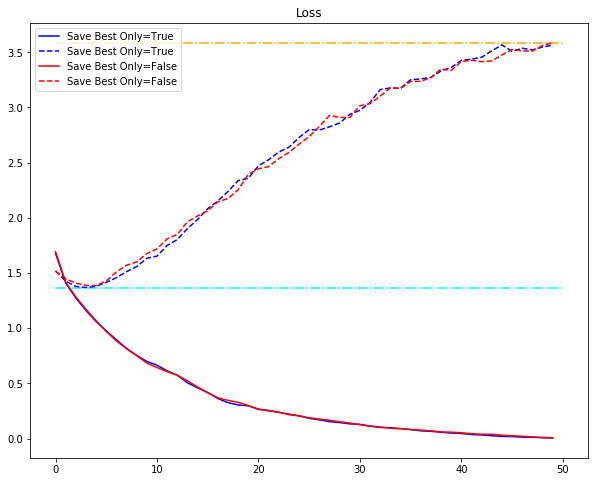

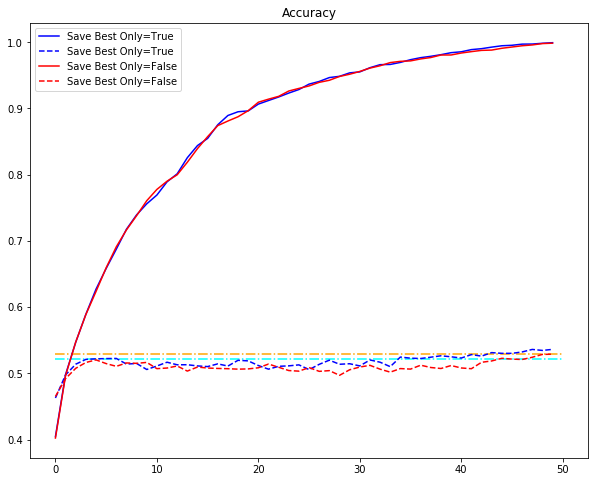

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ['blue','red']
hline_color = ['aqua','orange']

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.hlines(y = results[cond]['loss_loadback'], xmin=0, xmax=len(results[cond]['train-loss']), 
               colors=hline_color[i], linestyles='-.')
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.hlines(y = results[cond]['acc_loadback'], xmin=0, xmax=len(results[cond]['train-loss']), 
               colors=hline_color[i], linestyles='-.')
plt.title("Accuracy")
plt.legend()
plt.show()